# INTRODUCTION

Competition: https://codalab.lisn.upsaclay.fr/competitions/16684#learn_the_details-overview

The rapid growth of digital repositories and academic databases has led to an overwhelming abundance of scholarly articles. In the context of academic research, the task of categorizing these articles into genres or fields has become increasingly challenging. Assigning genres to academic papers, such as determining the specific area of study or field they belong to, is a crucial step for effective organization, searchability, and recommendation systems.

In this work, we aim to address the challenge of automatically assigning genres to academic papers by leveraging graph-based methods and label propagation techniques. Our approach capitalizes on the interconnected nature of academic content, where papers, authors, and words are linked in a complex web of relationships. We focus on three primary elements in our dataset: the title of the paper, the abstract, and the authorship information.

The structure of our dataset consists of academic papers, each associated with metadata including the title, abstract, and the authors involved. We recognize the interdisciplinary nature of many papers, making it a non-trivial task to categorize them accurately. To enhance our model's performance, we propose a comprehensive method that considers both the content of the papers and the relationships between authors and papers.

Our methodology involves constructing a graph-based representation of the academic network, where nodes represent papers, authors, and words, and edges signify relationships such as authorship and word occurrences. By incorporating graph-based algorithms, we can capture the inherent relationships within the academic domain. Additionally, we employ label propagation techniques to iteratively assign genres to papers based on their connections within the academic network.

To illustrate our approach, we present two distinct scenarios. First, we explore the assignment of genres to papers that lack explicit genre labels. Second, we delve into the propagation of genre information to papers with known genres but possibly incomplete or inaccurate labels.

Our work is motivated by the ambition to enhance the organization and discoverability of academic papers, facilitating more efficient literature reviews, targeted searches, and personalized recommendations. By proposing a model that leverages the interconnected nature of academic content, we contribute to the ongoing efforts in automating genre assignment and improving the accessibility of scholarly knowledge.

In [1]:
import pandas as pd
import numpy as np
import math
import re
import transformers
import tensorflow as tf
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
import json
import pickle
import networkx as nx #For network creation/analysis
#!pip install pygraphviz
import itertools
import matplotlib.pyplot as plt #For plotting graphs
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import List, Dict, Optional


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 1. GRAPHS: Author and Paper Relationship


In this case, we are constructing a simple graph with connections between author nodes and book nodes. If an author has written the book or is a co-author, there will be a connection; otherwise, there won't be. Through a label propagation algorithm, we will label the genre of the nearest connection for those books that are not labeled. In this straightforward scenario, if the author of an unlabeled book is not connected to the other authors in the training set, no label propagation can be performed. This means that if an author of an unlabeled book doesn't have a direct or indirect connection with authors of labeled books, we won't be able to infer the genre label for that book through the label propagation algorithm.

In [2]:
def add_nodes_edges_graph(G, df,
                          author_c='Author', id_title_c='Book', label_c='Genre',
                          weight=1):
    for index, row in df.iterrows():
        author = row[author_c]
        label = row[label_c]
        id_title = row[id_title_c]

        if not G.has_node(author):
            G.add_node(author)

        if not G.has_node(id_title):
            G.add_node(id_title, label=label)

        G.add_edge(author, id_title, weight=weight)
    return G

In [3]:
def propagate_label(G, df_new, author_c='Author', id_title_c='Book',
                    label_c='Genre', distance_weight=None):
    df_labeled = df_new.copy()
    # Comprobar nodos en df_new están en el grafo G
    for author_new in df_labeled[author_c].unique():
        if not G.has_node(author_new):
            G.add_node(author_new, Label=None)

    # Propagar etiquetas desde nodos existentes (autores) a nodos nuevos (id_title)
    for index, row in df_labeled.iterrows():
        author_new = row[author_c]
        # Verificar si hay nodos en G antes de intentar calcular distancias
        if len(G) > 0:
            # Calcular la distancia desde el nuevo autor
            distances = nx.shortest_path_length(G, source=author_new,
                                                target=None,
                                                weight=distance_weight,
                                                method="dijkstra")
            # Eliminar distancias == 0
            distances_no_0 = {x: y for x, y in distances.items() if y != 0}
            # Verificar si hay nodos en G después de eliminar distancias == 0
            if len(distances_no_0) > 0:
                nearest_node_existing = min(distances_no_0, key=distances_no_0.get)
                label_propagated = G.nodes[nearest_node_existing].get('label', None)
            else:
                label_propagated = None
        else:
            label_propagated = None

        id_new = row[id_title_c]
        if not G.has_node(id_new):
            G.add_node(id_new, label=label_propagated)
        G.add_edge(author_new, id_new, weight=1)

        df_labeled.at[index, label_c] = label_propagated

    return G, df_labeled

In [4]:
# Crear un DataFrame de ejemplo - Train
data_train = {'Author': ['Author1', 'Author2', 'Author3', 'Author4'],
              'Book': ['Book A', 'Book A', 'Book A', 'Book B'],
              'Genre': ['Scify', 'Scify', 'Scify', 'Drama'],
              'Summary': [
                  'An exciting fiction story that will keep you glued to the pages.',
                  'An exciting fiction story that will keep you glued to the pages.',
                  'An exciting fiction story that will keep you glued to the pages.',
                  'An informative and educational journey through intriguing topics in this book.']}
df_train = pd.DataFrame(data_train)

# Crear un DataFrame de ejemplo - Validation
data_new = {'Author': ['Author3', 'Author4'],
            'Book': ['Book C', 'Book D'],
            'Genre': [None, None],
            'Summary': [
                    'Discover the genre of this book full of mystery and emotion.',
                    'Immerse yourself in the intriguing plot of this non-fiction gem.',
            ]}
df_new = pd.DataFrame(data_new)

In [5]:
# Crear un grafo no dirigido
G = nx.Graph()

In [6]:
G = add_nodes_edges_graph(G, df_train)

In [7]:
G, df_new_labeled = propagate_label(G, df_new, author_c='Author', id_title_c='Book', label_c='Genre')

In [8]:
nodes = nx.nodes(G)
labels = nx.get_node_attributes(G, "label")
edges = nx.edges(G)
edges_weights = nx.get_edge_attributes(G, 'weight')

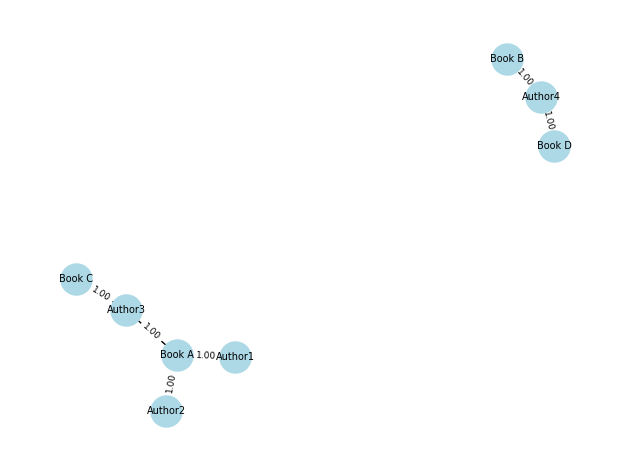

In [9]:
#pos = nx.nx_agraph.graphviz_layout(G)
pos = nx.spring_layout(G)
# nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
# edges
nx.draw_networkx_edges(G, pos, width=1)

# node labels
nx.draw_networkx_labels(G, pos, font_size=7, font_family="sans-serif")
# edge weight labels
#edge_labels = nx.get_edge_attributes(G, "weight")
edge_labels = dict([((u,v,), f"{d['weight']:.2f}") for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6.5)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

## 2. GRAPHS: tfidf


In this section, we will construct a graph to capture the relationships between authors, the books they have written, and the words present in the summaries of those books. The graph will be directed and will include nodes representing authors, books, and words. To weigh the relationships between words in the summaries and the respective books, we will leverage the TF-IDF (Term Frequency-Inverse Document Frequency) values. TF-IDF provides a measure of the importance of words in the context of specific documents.

The construction of the graph involves adding nodes for authors, books, and words, and edges to represent connections between them. The edges between book and word nodes will be weighted using the inverse of the TF-IDF values. This weighting scheme ensures that words with higher TF-IDF values, indicating their significance within a specific book, contribute more strongly to the graph's structure

In our context, the higher the TF-IDF value for a word associated with a book, the more relevant and specific that word is to that particular book. To reflect this relationship, when calculating the weights of connections between book and word nodes, we take the exponential inverse of the TF-IDF value. Thus, terms with higher TF-IDF values will have higher weights in connections, indicating a stronger relationship with the book.

On the other hand, we assign a low weight to connections between author and book nodes (*author_weight*), as they represent a more direct relationship. This assignment aims to reflect the narrower and more direct nature of the connection between an author and their books. With this combination of weights, we aim to effectively model relationships in the graph, emphasizing the importance of specific words for each book and the more direct connection between authors and books.

The ultimate goal is to assign fuzzy labels to each book, indicating the degree of membership in different genres. To build the model, we start with a set of books with their assigned genres and another set with unassigned genres, but where we know the true genre. For the unassigned set, we calculate fuzzy genres based on the connections in the graph we've constructed. Simultaneously, we also create these fuzzy labels for the labeled set used to propagate labels. In this case, we assign a high fixed value (*self_weigth*) for the correct label and calculate the membership to the nearest genres, similar to what we've done for the unlabeled set. This way, for the entire dataset, we have fuzzy labels indicating membership in the closest genres and their true labels.

In [10]:
def tokenize_text(text, tokenizer, max_length=512):
    tokens_ids = tokenizer.encode(text, add_special_tokens=False, truncation=True, max_length=512)
    tokens_strings = tokenizer.convert_ids_to_tokens(tokens_ids, skip_special_tokens=True)
    return tokens_strings

In [11]:
'''
def create_tfidf_df(df_input, tokenizer, vocabulary, column='full_text'):
    df_input['tokens'] = df_input[column].apply(tokenize_text, tokenizer=tokenizer)
    df_input['tokens_as_strings'] = df_input['tokens'].apply(lambda tokens: ' '.join(tokens))
    tfidf_vectorizer = TfidfVectorizer(vocabulary=vocabulary, lowercase=False)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_input['tokens_as_strings'])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    df_input = pd.concat([df_input.drop(columns=['tokens', 'tokens_as_strings', f'{column}']
                                        ),
                          df_tfidf], axis=1)
    return df_input, feature_names
'''

"\ndef create_tfidf_df(df_input, tokenizer, vocabulary, column='full_text'):\n    df_input['tokens'] = df_input[column].apply(tokenize_text, tokenizer=tokenizer)\n    df_input['tokens_as_strings'] = df_input['tokens'].apply(lambda tokens: ' '.join(tokens))\n    tfidf_vectorizer = TfidfVectorizer(vocabulary=vocabulary, lowercase=False)\n    tfidf_matrix = tfidf_vectorizer.fit_transform(df_input['tokens_as_strings'])\n    feature_names = tfidf_vectorizer.get_feature_names_out()\n    df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)\n    df_input = pd.concat([df_input.drop(columns=['tokens', 'tokens_as_strings', f'{column}']\n                                        ),\n                          df_tfidf], axis=1)\n    return df_input, feature_names\n"

In [12]:
'''
def add_nodes_edges_graph_tfidf(G, df, features_names, is_new=None, alpha_word_weight=2,
                                author_weight=0.90,
                                author_c='Author_0', id_title_c='Book_0', label_c='Genre_0'):
    # Ajustar el peso inversamente proporcional del autor
    inverse_author_weight = math.exp(-alpha_word_weight * author_weight)
    for index, row in df.iterrows():
        author = row[author_c]
        id_title = row[id_title_c]
        label = row[label_c]
        if is_new:
            G.add_node(id_title, label=None, original_label=label, is_title=1, is_new=is_new)
        else:
            G.add_node(id_title, label=[{label: inverse_author_weight}],
                       original_label=label, is_title=1, is_new=None)
        G.add_node(author, label=None, is_title=None)
        for token in feature_names:
            w = row[token]
            if w > 0:
                G.add_node(token, label=None, is_title=None)
                # Ajustar el peso inversamente proporcional al valor del TF-IDF
                inverse_weight = math.exp(-alpha_word_weight * w)
                G.add_edge(id_title, token, weight=inverse_weight)
                G.add_edge(author, id_title, weight=inverse_author_weight)
    return G
'''

"\ndef add_nodes_edges_graph_tfidf(G, df, features_names, is_new=None, alpha_word_weight=2,\n                                author_weight=0.90,\n                                author_c='Author_0', id_title_c='Book_0', label_c='Genre_0'):\n    # Ajustar el peso inversamente proporcional del autor\n    inverse_author_weight = math.exp(-alpha_word_weight * author_weight)\n    for index, row in df.iterrows():\n        author = row[author_c]\n        id_title = row[id_title_c]\n        label = row[label_c]\n        if is_new:\n            G.add_node(id_title, label=None, original_label=label, is_title=1, is_new=is_new)\n        else:\n            G.add_node(id_title, label=[{label: inverse_author_weight}],\n                       original_label=label, is_title=1, is_new=None)\n        G.add_node(author, label=None, is_title=None)\n        for token in feature_names:\n            w = row[token]\n            if w > 0:\n                G.add_node(token, label=None, is_title=None)\n          

In [13]:
def compute_labels_for_unlabeled_nodes(G, distance_weight=None,
                                       label_attr='label', num_closest_labels=3):
    unlabeled_nodes = [node for node in G.nodes if G.nodes[node].get(label_attr) is None]
    dict_distances = {}

    for unlabeled_node in unlabeled_nodes:
        distances = nx.single_source_dijkstra_path_length(G, unlabeled_node, weight=distance_weight)
        dict_distances[unlabeled_node] = {}

        # Filtrar los nodos más cercanos que están previamente etiquetados y tienen el atributo id_title=1
        closest_labels = [(labeled_node, distance) for labeled_node, distance in distances.items()
                          if G.nodes[labeled_node].get(label_attr) is not None
                          and G.nodes[labeled_node].get('is_title') == 1
                          and G.nodes[labeled_node].get('is_new') is None][:num_closest_labels]

        for labeled_node, distance in closest_labels:
            labeled_node_label = G.nodes[labeled_node].get(label_attr)
            dict_distances[unlabeled_node][labeled_node] = {'distance': distance,
                                                            'label': labeled_node_label}
        
        # Añadir el atributo de etiqueta al nodo no etiquetado
        #G.nodes[unlabeled_node][label_attr] = dict_distances[unlabeled_node]
        G.nodes[unlabeled_node][label_attr] = [{list(dict_distances[unlabeled_node].get(title).get('label')[0].keys())[0]:
                                                dict_distances[unlabeled_node].get(title).get('distance')
                                                 } for title in dict_distances[unlabeled_node].keys()]
    return G

In [14]:
def compute_labels_for_unlabeled_labeled_nodes(G, distance_weight=None,
                                               label_attr='label', num_closest_labels=3):
    unlabeled_nodes = [node for node in G.nodes if G.nodes[node].get(label_attr) is None]
    labeled_nodes_original = [node for node in G.nodes if G.nodes[node].get('is_new') is None]
    dict_distances = {}
    dict_distances_original = {}

    for unlabeled_node in unlabeled_nodes:
        distances = nx.single_source_dijkstra_path_length(G, unlabeled_node, weight=distance_weight)
        dict_distances[unlabeled_node] = {}
        # Filtrar los nodos más cercanos que están previamente etiquetados y tienen el atributo id_title=1
        closest_labels = [(labeled_node, distance) for labeled_node, distance in distances.items()
                          if G.nodes[labeled_node].get(label_attr) is not None
                          and G.nodes[labeled_node].get('is_title') == 1
                          and G.nodes[labeled_node].get('is_new') is None][:num_closest_labels]

        for labeled_node, distance in closest_labels:
            labeled_node_label = G.nodes[labeled_node].get(label_attr)
            dict_distances[unlabeled_node][labeled_node] = {'distance': distance,
                                                            'label': labeled_node_label}
        
        # Añadir el atributo de etiqueta al nodo no etiquetado
        G.nodes[unlabeled_node][label_attr] = [{list(dict_distances[unlabeled_node].get(title).get('label')[0].keys())[0]:
                                                dict_distances[unlabeled_node].get(title).get('distance')
                                                 } for title in dict_distances[unlabeled_node].keys()]
    for labeled_node_o in labeled_nodes_original:
        distances = nx.single_source_dijkstra_path_length(G, labeled_node_o, weight=distance_weight)
        dict_distances_original[labeled_node_o] = {}
        # Filtrar los nodos más cercanos que están previamente etiquetados y tienen el atributo id_title=1
        closest_labels = [(labeled_node, distance) for labeled_node, distance in distances.items()
                          if G.nodes[labeled_node].get(label_attr) is not None
                          and G.nodes[labeled_node].get('is_title') == 1
                          and G.nodes[labeled_node].get('is_new') is None][:num_closest_labels]

        for labeled_node, distance in closest_labels:
            labeled_node_label = G.nodes[labeled_node].get(label_attr)
            dict_distances_original[labeled_node_o][labeled_node] = {'distance': distance,
                                                                     'label': labeled_node_label}
        G.nodes[labeled_node_o][label_attr] = [{list(dict_distances_original[labeled_node_o].get(title).get('label')[0].keys())[0]:
                                                dict_distances_original[labeled_node_o].get(title).get('distance')
                                                 } for title in dict_distances_original[labeled_node_o].keys()]
    return G

In [15]:
def complete_matrix_with_zeros(input_dict, unique_labels):
    result_list = []
    key_list = []
    for key, value in input_dict.items():
        existing_labels = set(value.keys())
        missing_labels = set(unique_labels) - existing_labels
        for missing_label in missing_labels:
            value[missing_label] = 0.0
        '''
        # Ordenar las claves en el diccionario resultante -> Con claves
        sorted_labels = sorted(value.items(), key=lambda x: x[0])
        input_dict[key] = dict(sorted_labels)
        '''
        # Ordenar las claves en el diccionario resultante según el orden de unique_labels
        sorted_labels = sorted(value.items(), key=lambda x: unique_labels.index(x[0]))
        result_list.append(list(dict(sorted_labels).values()))
        key_list.append(key)
    return result_list, key_list

In [16]:
def transform_distance(w, a=2, self_weigth=0.95):
    if w==0:
        return self_weigth
    else:
        return (-math.log(w) / a)

In [17]:
# Crear un DataFrame de ejemplo - Train
data_train = {'Author': ['Author1', 'Author2', 'Author3', 'Author4'],
              'Book': ['Book A', 'Book A', 'Book A', 'Book B'],
              'Genre': ['Scify', 'Scify', 'Scify', 'Drama'],
              'Summary': [
                  'An exciting fiction story that will keep you glued to the pages.',
                  'An exciting fiction story that will keep you glued to the pages.',
                  'An exciting fiction story that will keep you glued to the pages.',
                  'An informative and educational journey through intriguing topics in this book.']}
df_train = pd.DataFrame(data_train)

# Crear un DataFrame de ejemplo - Validation
data_new = {'Author': ['Author3', 'Author4'],
            'Book': ['Book C', 'Book D'],
            'Genre_unlabeled': [None, None],
            'Genre': ['Scify', 'Drama'],
            'Summary': [
                    'Discover the genre of this book full of mystery and emotion.',
                    'Immerse yourself in the intriguing plot of this non-fiction gem.',
            ]}
df_new = pd.DataFrame(data_new)

## OPTIMIZED FUNCTIONS

In [18]:
def tokenize_text(text, tokenizer, max_length=512):
    tokens_ids = tokenizer.encode(text, add_special_tokens=False, truncation=True, max_length=512)
    tokens_strings = tokenizer.convert_ids_to_tokens(tokens_ids, skip_special_tokens=True)
    return tokens_strings

def create_tfidf_df(df_input, tokenizer, vocabulary, column='full_text'):
    # Tokenización

    #tokens = df_input[column].apply(tokenize_text, tokenizer=tokenizer)
    #tokens = np.vectorize(tokenize_text)(df_input[column], tokenizer=tokenizer)
    tokens = df_input[column].apply(lambda text: tokenize_text(text, tokenizer))

    # Concatenar tokens como strings
    tokens_as_strings = [' '.join(doc_tokens) for doc_tokens in tokens]

    # Crear la matriz TF-IDF
    tfidf_vectorizer = TfidfVectorizer(vocabulary=vocabulary, lowercase=False)
    tfidf_matrix = tfidf_vectorizer.fit_transform(tokens_as_strings)

    # Obtener los nombres de las características
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Concatenar las características TF-IDF con el resto de los datos
    data_array = df_input.drop(columns=[column]).to_numpy()
    tfidf_array = tfidf_matrix.toarray()
    data_with_tfidf = np.concatenate([data_array, tfidf_array], axis=1)

    return data_with_tfidf, feature_names

In [19]:
def add_nodes_edges_graph_tfidf(G, df, features_names, is_new=None, alpha_word_weight=2,
                                author_weight=0.90,
                                author_c=0, id_title_c=1, label_c=2):
    # Ajustar el peso inversamente proporcional del autor
    inverse_author_weight = math.exp(-alpha_word_weight * author_weight)

    for row in df:
        author = row[author_c]
        id_title = row[id_title_c]
        label = row[label_c]

        if is_new:
            G.add_node(id_title, label=None, original_label=label, is_title=1, is_new=is_new)
        else:
            G.add_node(id_title, label=[{label: inverse_author_weight}],
                       original_label=label, is_title=1, is_new=None)

        G.add_node(author, label=None, is_title=None)

        for i in range(len(feature_names)):
            w = row[i+4]
            token = feature_names[i]
            if isinstance(w, float):
                if w > 0:
                    G.add_node(token, label=None, is_title=None)
                    # Ajustar el peso inversamente proporcional al valor del TF-IDF
                    inverse_weight = math.exp(-alpha_word_weight * w)
                    G.add_edge(id_title, token, weight=inverse_weight)
                    G.add_edge(author, id_title, weight=inverse_author_weight)
            else:
                print(w)

    return G

Tokenizer

In [20]:
# Crear un tokenizer de BERT
tokenizer = transformers.DistilBertTokenizer.from_pretrained("OpenAlex/distilbert-base-cased-finetuned-topic-classification-title-abstract")

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [21]:
vocab_distilbert = tokenizer.get_vocab()

vocab_distilbert_alpha = [word for word in vocab_distilbert if re.match(r'^[a-zA-Z]+$', word)]

In [22]:
inv_vocab = {value: key for key, value in tokenizer.get_vocab().items()}

In [23]:
# Preprocessing train
df_train[["Book", "Summary"]] = df_train[["Book", "Summary"]].fillna("")
df_train["full_text"] = df_train[["Book", "Summary"]].apply(lambda x: " ".join(x).lower(), axis=1)
df_train = df_train.rename(columns={"Book":"Book_0", "Summary":"Summary_0", "Genre":"Genre_0", "Author":"Author_0"})
df_train = df_train[['Author_0', 'Book_0', 'Summary_0', 'Genre_0', 'full_text']]

In [24]:
# Create tfidf dataframe
df_train, feature_names = create_tfidf_df(df_input = df_train,
                                          vocabulary=vocab_distilbert_alpha,
                                          tokenizer=tokenizer, column='full_text')

In [25]:
# Create undirected graph
G2 = nx.Graph()

In [26]:
# Add nodes to graph
G2 = add_nodes_edges_graph_tfidf(G2, df=df_train, features_names=feature_names,
                                 author_weight=0.90,
                                 author_c=0, id_title_c=1, label_c=3)

**Propagate label to df_new**

Preprocessing:

In [27]:
df_new[["Book", "Summary"]] = df_new[["Book", "Summary"]].fillna("")
df_new["full_text"] = df_new[["Book", "Summary"]].apply(lambda x: " ".join(x).lower(), axis=1)
df_new = df_new.rename(columns={"Book": "Book_0", "Summary": "Summary_0",
                                "Genre": "Genre_0", "Author": "Author_0"})
df_new = df_new[['Author_0', 'Book_0', 'Summary_0', 'Genre_0', 'full_text']]

In [28]:
df_new, feature_names_new = create_tfidf_df(df_input = df_new, tokenizer=tokenizer,
                                            vocabulary=vocab_distilbert_alpha,
                                            column='full_text')

In [29]:
# Add test nodes to graph
G3 = add_nodes_edges_graph_tfidf(G2, df=df_new, features_names=feature_names,
                                 is_new=1,
                                 author_weight=0.90,
                                 author_c=0, id_title_c=1, label_c=3)

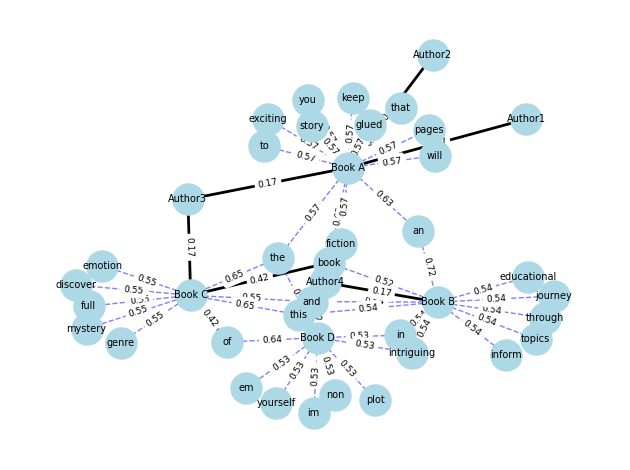

In [30]:
G = G3

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] < 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] >= 0.5]
#pos = nx.nx_agraph.graphviz_layout(G)
pos = nx.spring_layout(G)
# nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=2)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=1, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=7, font_family="sans-serif")
# edge weight labels
#edge_labels = nx.get_edge_attributes(G, "weight")
edge_labels = dict([((u,v,), f"{d['weight']:.2f}") for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6.5)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [31]:
G3 = compute_labels_for_unlabeled_labeled_nodes(G3, distance_weight='weight', label_attr='label',
                                                num_closest_labels=3)

In [32]:
nodes = nx.nodes(G3)
titles = nx.get_node_attributes(G3, "is_title")
labels = nx.get_node_attributes(G3, "label")
labels_original = nx.get_node_attributes(G3, "original_label")
edges = nx.edges(G3)
edges_weights = nx.get_edge_attributes(G3, 'weight')

In [33]:
book_nodes = [node for node in G3.nodes if G3.nodes[node].get('is_title') == 1]
fuzzy_labels_nodes = [{book_node: labels[book_node]} for book_node in book_nodes]

In [34]:
fuzzy_labels_distances = {}

for item in fuzzy_labels_nodes:
    for title, label_distances in item.items():
        if title not in fuzzy_labels_distances:
            fuzzy_labels_distances[title] = {}
        for label_distance in label_distances:
            for label, distance in label_distance.items():
                # Aplicar la función de transformación
                transformed_distance = transform_distance(distance)
                fuzzy_labels_distances[title][label] = transformed_distance

In [35]:
unique_labels = ['Scify', 'Drama']
result_matrix, ids_books = complete_matrix_with_zeros(fuzzy_labels_distances, unique_labels=unique_labels)
y_labels = [value for value in labels_original.values()]

# Fuzzy Network

In [36]:
'''
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense
from tensorflow.keras.models import Model

# Generate synthetic data
np.random.seed(0)
X = np.random.uniform(-1, 1, (100, 2))  # 100 samples, 2 features
y = X[:, 0]**2 + X[:, 1]**2 + np.random.normal(0, 0.1, 100)  # Quadratic function with noise

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Custom Fuzzy Layer
class FuzzyLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        super(FuzzyLayer, self).__init__(**kwargs)
        self.output_dim = output_dim

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)

    def call(self, x):
        return tf.math.sigmoid(tf.matmul(x, self.kernel))

# Neural Network Model
input_layer = Input(shape=(2,))
fuzzy_layer = FuzzyLayer(10)(input_layer)
hidden_layer = Dense(10, activation='relu')(fuzzy_layer)
output_layer = Dense(1)(hidden_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=2, batch_size=10, verbose=1)

# Evaluate the model
predictions = model.predict(X_test)
mse = np.mean((y_test - predictions.flatten())**2)
print("Mean Squared Error:", mse)

# Plotting results
plt.scatter(X_test[:,0], y_test, label='True')
plt.scatter(X_test[:,0], predictions, label='Predicted')
plt.legend()
plt.title("Fuzzy Neural Network Predictions")
plt.show()
'''

'\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport tensorflow as tf\nfrom tensorflow.keras.layers import Layer, Input, Dense\nfrom tensorflow.keras.models import Model\n\n# Generate synthetic data\nnp.random.seed(0)\nX = np.random.uniform(-1, 1, (100, 2))  # 100 samples, 2 features\ny = X[:, 0]**2 + X[:, 1]**2 + np.random.normal(0, 0.1, 100)  # Quadratic function with noise\n\n# Split the data into training and testing sets\ntrain_size = int(len(X) * 0.8)\nX_train, X_test = X[:train_size], X[train_size:]\ny_train, y_test = y[:train_size], y[train_size:]\n\n# Custom Fuzzy Layer\nclass FuzzyLayer(Layer):\n    def __init__(self, output_dim, **kwargs):\n        super(FuzzyLayer, self).__init__(**kwargs)\n        self.output_dim = output_dim\n\n    def build(self, input_shape):\n        self.kernel = self.add_weight(name=\'kernel\', \n                                      shape=(input_shape[1], self.output_dim),\n                                      initializer=\'uniform\',\n  

# 1. REAL DATA

# 0. Load data

In [37]:
train = pd.read_csv('/kaggle/input/paperstask/train.csv', sep=",", header=0)
val = pd.read_csv('/kaggle/input/paperstask/val.csv', sep=",", header=0)

data = train

# 1. Data understanding

<Axes: >

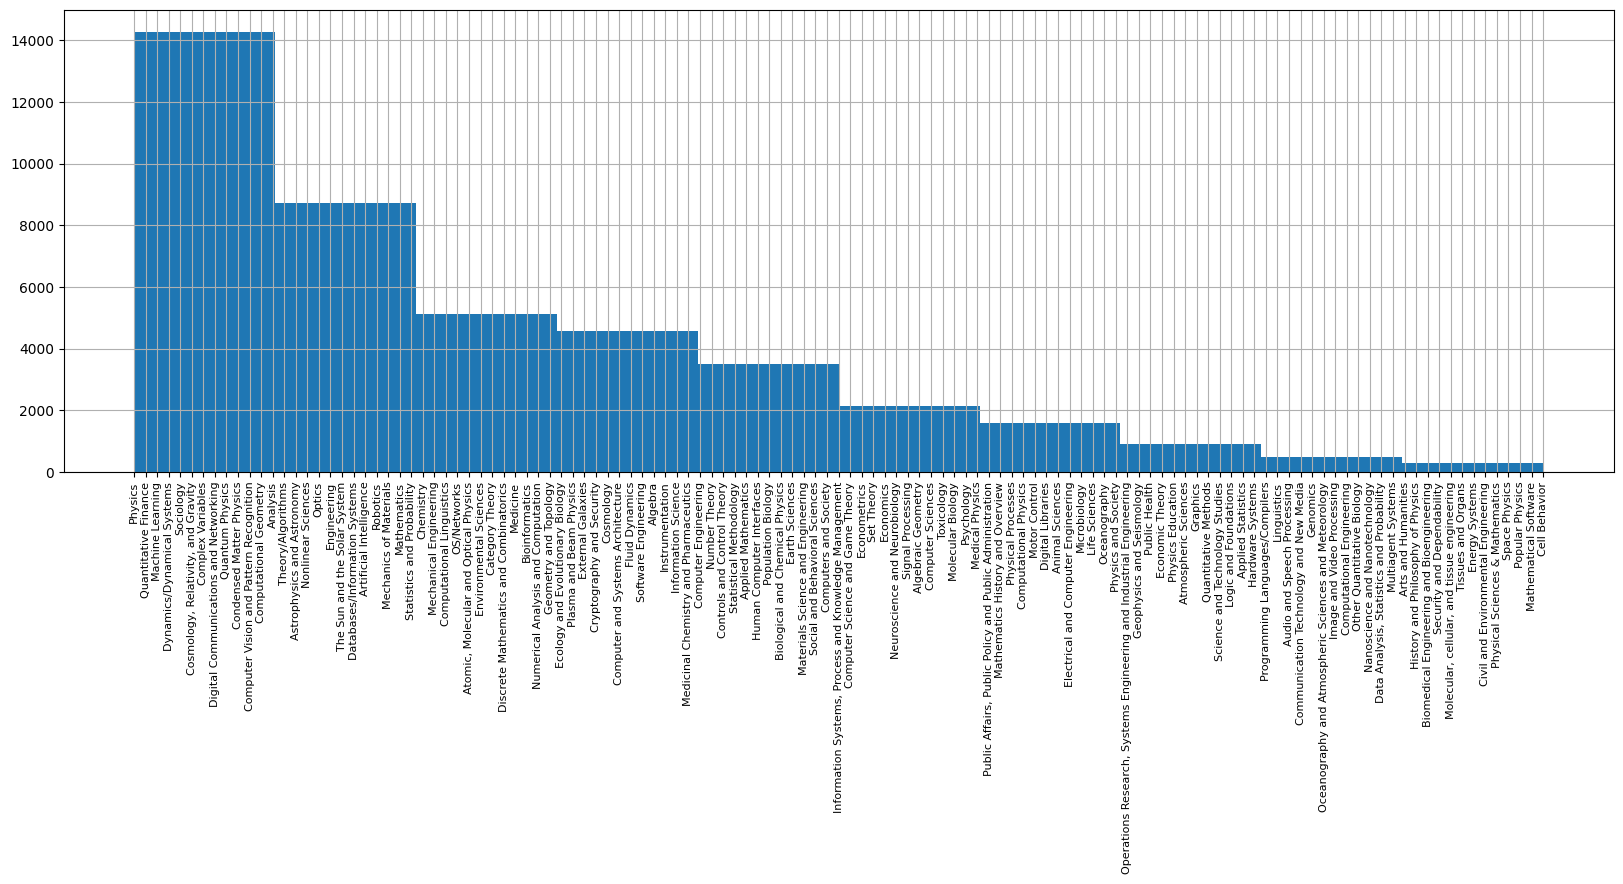

In [38]:
data["label"].hist(xrot=90, xlabelsize=8, figsize=(20, 6))

In [39]:
np.percentile([len(str(abstract).split(" ")) for abstract in data["abstract"].values],
              [0, 25, 50, 75, 95, 99, 100]).astype(np.int32)

array([   1,   86,  131,  186,  267,  307, 4868], dtype=int32)

In [40]:
np.percentile([len(str(title).split(" ")) for title in data["title"].values],
              [0, 25, 50, 75, 95, 99, 100]).astype(np.int32)

array([ 1,  7, 10, 13, 18, 23, 40], dtype=int32)

In [41]:
np.percentile([len(str(publisher).split(" ")) for publisher in data["publisher"].values],
              [0, 25, 50, 75, 95, 99, 100]).astype(np.int32)

array([ 1,  1,  1,  4,  9, 16, 42], dtype=int32)

# 2. Data preprocessing

## Author

In [42]:
def clean(name: str) -> str:
    name = name.replace('(1)', '')
    name = name.replace('(2)', '')
    name = name.replace('(3)', '')
    name = name.strip()
    name = " ".join(name.split())
    if name.startswith("["):
        name = name[1:]
    if name.startswith("'"):
        name = name[1:]
    if name.endswith("'"):
        name = name[:-1]
    if name.endswith("]"):
        name = name[:-1]
    return name.strip()
    
def split(text) -> List[str]:
    if isinstance(text, list):
        return text
    return [clean(name) for name in re.split(r", and|,", text)]

In [43]:
data["author"] = data["author"].apply(lambda x: split(str(x)))

In [44]:
np.concatenate(data["author"].values).shape, np.unique(np.concatenate(data["author"].values)).shape

((186298,), (136255,))

In [45]:
#data = data.sample(100, ignore_index=True)#.reset_index()

## Classes

In [46]:
class2id = {c: i for i, c in enumerate(np.unique(data["label"].values))}
id2class = {value: key for key, value in class2id.items()}

## Train/test

In [47]:
idx_train, idx_test = train_test_split(range(len(data)), 
                                       test_size=0.3,
                                       stratify=data["label"].values,
                                       random_state=999)

In [48]:
idx_train, idx_test = train_test_split(range(len(data)), 
                                       test_size=0.3,
                                       stratify=data["label"].values,
                                       random_state=999)

## Class Weights

In [49]:
data["label"] = data["label"].apply(lambda x: class2id[x])

In [50]:
unique, counts = np.unique(data["label"].values, return_counts=True)
weights = dict(zip(unique, counts))

In [51]:
weights = {key: (1 - (value / np.sum(list(weights.values()))))
           for key, value in weights.items()}

In [52]:
weights = {key: ((value - np.min(list(weights.values()))) / (np.max(list(weights.values())) - np.min(list(weights.values())))) + 1
           for key, value in weights.items()}

## 3. Graphs

### 3.1 Preprocessing and graph creation

In [53]:
df = data

Explode authors

In [54]:
df = df.explode('author')

In [55]:
df_train = df.loc[idx_train].reset_index() # Comentar reset_index
df_test = df.loc[idx_test].reset_index() # Comentar reset_index

### Author - Paper Graph

In [56]:
# Crear un grafo no dirigido
# G1 = nx.Graph()

In [57]:
'''
G1 = add_nodes_edges_graph(G=G1, df=df_train,
                           author_c='author', id_title_c='data_index', label_c='label',
                           weight=1)
'''

"\nG1 = add_nodes_edges_graph(G=G1, df=df_train,\n                           author_c='author', id_title_c='data_index', label_c='label',\n                           weight=1)\n"

In [58]:
#df_test['label_propagated'] = None

In [59]:
#G1, df_test_propagated = propagate_label(G1, df_test, author_c='author', id_title_c='data_index', label_c='label_propagated')

In [60]:
'''
# save graph object to file
pickle.dump(G1, open('/kaggle/working/G1_author_paper.pickle', 'wb'))

# load graph object from file
#G = pickle.load(open('/kaggle/working/dummy.pickle', 'rb'))

df_test_propagated.to_csv('/kaggle/working/df_test_g1.csv')
'''

"\n# save graph object to file\npickle.dump(G1, open('/kaggle/working/G1_author_paper.pickle', 'wb'))\n\n# load graph object from file\n#G = pickle.load(open('/kaggle/working/dummy.pickle', 'rb'))\n\ndf_test_propagated.to_csv('/kaggle/working/df_test_g1.csv')\n"

In [61]:
# Read df_test -> implode and calculate categorical accuracy

## tfidf

In [62]:
'''# Preprocessing train
df_train[["title", "publisher", "abstract"]] = df_train[["title", "publisher", "abstract"]].fillna("")
df_train["full_text"] = df_train[["title", "publisher", "abstract"]].apply(lambda x: " ".join(x), axis=1)
df_train = df_train.rename(columns={"title": "title_0", "publisher": "publisher_0",
                                    "abstract": "abstract_0", "author": "author_0", "label": "label_0",
                                    "index": "index_0", "doi": "doi_0"})
df_train = df_train[['author_0', 'title_0', 'index_0', 'label_0', 'full_text']]'''

'# Preprocessing train\ndf_train[["title", "publisher", "abstract"]] = df_train[["title", "publisher", "abstract"]].fillna("")\ndf_train["full_text"] = df_train[["title", "publisher", "abstract"]].apply(lambda x: " ".join(x), axis=1)\ndf_train = df_train.rename(columns={"title": "title_0", "publisher": "publisher_0",\n                                    "abstract": "abstract_0", "author": "author_0", "label": "label_0",\n                                    "index": "index_0", "doi": "doi_0"})\ndf_train = df_train[[\'author_0\', \'title_0\', \'index_0\', \'label_0\', \'full_text\']]'

In [63]:
'''# Preprocessing train
df_test[["title", "publisher", "abstract"]] = df_test[["title", "publisher", "abstract"]].fillna("")
df_test["full_text"] = df_test[["title", "publisher", "abstract"]].apply(lambda x: " ".join(x), axis=1)
df_test["label_test"] = None
df_test = df_test.rename(columns={"title": "title_0", "publisher": "publisher_0",
                                  "abstract": "abstract_0", "author": "author_0", "label": "label_0",
                                  "index": "index_0", "doi": "doi_0"})
df_test = df_test[['author_0', 'title_0', 'index_0', 'label_0', 'full_text']]'''

'# Preprocessing train\ndf_test[["title", "publisher", "abstract"]] = df_test[["title", "publisher", "abstract"]].fillna("")\ndf_test["full_text"] = df_test[["title", "publisher", "abstract"]].apply(lambda x: " ".join(x), axis=1)\ndf_test["label_test"] = None\ndf_test = df_test.rename(columns={"title": "title_0", "publisher": "publisher_0",\n                                  "abstract": "abstract_0", "author": "author_0", "label": "label_0",\n                                  "index": "index_0", "doi": "doi_0"})\ndf_test = df_test[[\'author_0\', \'title_0\', \'index_0\', \'label_0\', \'full_text\']]'

In [64]:
'''
# Create tfidf dataframe train
df_train, feature_names  = create_tfidf_df(df_input = df_train,
                                           vocabulary=vocab_distilbert_alpha,
                                           tokenizer=tokenizer, column='full_text')
'''

"\n# Create tfidf dataframe train\ndf_train, feature_names  = create_tfidf_df(df_input = df_train,\n                                           vocabulary=vocab_distilbert_alpha,\n                                           tokenizer=tokenizer, column='full_text')\n"

In [65]:
#saving array
#np.save('df_train',df_train)

In [66]:
#df_train.to_csv('/kaggle/working/df_train_tfidf.csv')

In [67]:
'''# Create tfidf dataframe test
df_test, feature_names = create_tfidf_df(df_input = df_test,
                                         vocabulary=vocab_distilbert_alpha,
                                         tokenizer=tokenizer, column='full_text')'''

"# Create tfidf dataframe test\ndf_test, feature_names = create_tfidf_df(df_input = df_test,\n                                         vocabulary=vocab_distilbert_alpha,\n                                         tokenizer=tokenizer, column='full_text')"

In [68]:
'''#saving array
# np.save('df_test', df_test)

#df_test.to_csv('/kaggle/working/df_test_tfidf.csv')'''

"#saving array\n# np.save('df_test', df_test)\n\n#df_test.to_csv('/kaggle/working/df_test_tfidf.csv')"

In [69]:
'''# Create undirected graph
G2 = nx.Graph()'''

'# Create undirected graph\nG2 = nx.Graph()'

In [70]:
'''# Add nodes to graph
G2 = add_nodes_edges_graph_tfidf(G2, df=df_train, features_names=feature_names,
                                 is_new=None, alpha_word_weight=2,
                                 author_weight=0.90, 
                                 #author_c='author_0', id_title_c='data_index', label_c='label_0')
                                 author_c=0, id_title_c=2, label_c=3)'''

"# Add nodes to graph\nG2 = add_nodes_edges_graph_tfidf(G2, df=df_train, features_names=feature_names,\n                                 is_new=None, alpha_word_weight=2,\n                                 author_weight=0.90, \n                                 #author_c='author_0', id_title_c='data_index', label_c='label_0')\n                                 author_c=0, id_title_c=2, label_c=3)"

In [71]:
'''# Add test nodes to graph
G3 = add_nodes_edges_graph_tfidf(G2, df=df_test, features_names=feature_names,
                                 author_weight=0.90, is_new=1,
                                 #author_c='author_0', id_title_c='data_index', label_c='label_0')
                                 author_c=0, id_title_c=2, label_c=3)'''

"# Add test nodes to graph\nG3 = add_nodes_edges_graph_tfidf(G2, df=df_test, features_names=feature_names,\n                                 author_weight=0.90, is_new=1,\n                                 #author_c='author_0', id_title_c='data_index', label_c='label_0')\n                                 author_c=0, id_title_c=2, label_c=3)"

In [72]:
'''G4 = compute_labels_for_unlabeled_labeled_nodes(G3, distance_weight='weight', label_attr='label',
                                                num_closest_labels=100)'''

"G4 = compute_labels_for_unlabeled_labeled_nodes(G3, distance_weight='weight', label_attr='label',\n                                                num_closest_labels=100)"

In [73]:
'''# save graph object to file
pickle.dump(G4, open('/kaggle/working/G4_tfidf.pickle', 'wb'))

# load graph object from file
#G = pickle.load(open('/kaggle/working/dummy.pickle', 'rb'))'''

"# save graph object to file\npickle.dump(G4, open('/kaggle/working/G4_tfidf.pickle', 'wb'))\n\n# load graph object from file\n#G = pickle.load(open('/kaggle/working/dummy.pickle', 'rb'))"

In [74]:
'''nodes = nx.nodes(G4)
titles = nx.get_node_attributes(G4, "is_title")
labels = nx.get_node_attributes(G4, "label")
labels_original = nx.get_node_attributes(G4, "original_label")
edges = nx.edges(G4)
edges_weights = nx.get_edge_attributes(G4, 'weight')'''

'nodes = nx.nodes(G4)\ntitles = nx.get_node_attributes(G4, "is_title")\nlabels = nx.get_node_attributes(G4, "label")\nlabels_original = nx.get_node_attributes(G4, "original_label")\nedges = nx.edges(G4)\nedges_weights = nx.get_edge_attributes(G4, \'weight\')'

In [75]:
'''book_nodes = [node for node in G4.nodes if G4.nodes[node].get('is_title') == 1 and G4.nodes[node]]
fuzzy_labels_nodes = [{book_node: labels[book_node]} for book_node in book_nodes]'''

"book_nodes = [node for node in G4.nodes if G4.nodes[node].get('is_title') == 1 and G4.nodes[node]]\nfuzzy_labels_nodes = [{book_node: labels[book_node]} for book_node in book_nodes]"

In [76]:
'''fuzzy_labels_distances = {}

for item in fuzzy_labels_nodes:
    for title, label_distances in item.items():
        if title not in fuzzy_labels_distances:
            fuzzy_labels_distances[title] = {}
        for label_distance in label_distances:
            for label, distance in label_distance.items():
                # Aplicar la función de transformación
                transformed_distance = transform_distance(distance)
                fuzzy_labels_distances[title][label] = transformed_distance'''

'fuzzy_labels_distances = {}\n\nfor item in fuzzy_labels_nodes:\n    for title, label_distances in item.items():\n        if title not in fuzzy_labels_distances:\n            fuzzy_labels_distances[title] = {}\n        for label_distance in label_distances:\n            for label, distance in label_distance.items():\n                # Aplicar la función de transformación\n                transformed_distance = transform_distance(distance)\n                fuzzy_labels_distances[title][label] = transformed_distance'

In [77]:
'''result_matrix, ids_books = complete_matrix_with_zeros(fuzzy_labels_distances, unique_labels=list(unique))
y_labels = [value for value in labels_original.values()]'''

'result_matrix, ids_books = complete_matrix_with_zeros(fuzzy_labels_distances, unique_labels=list(unique))\ny_labels = [value for value in labels_original.values()]'